## Bibliotecas y funciones



Primero cargamos las bibliotecas de Python que vamos a necesitar y definimos algunas funciones. Usamos la biblioteca estándar `csv`, las bibliotecas `numpy`, `pandas`, `matplotlib` y `networkx`.

La función `graph_from_csv` tiene como argumento un archivo `.csv` y regresa una gráfica con pesos, donde los nodos se llaman como las columnas y renglones del archivo `.csv`.

La función `Fiedler` tiene como argumento una gráfica (con o sin pesos). Devuelve la conectividad algebraica, un vector Fiedler, y el resto de los eigenvalores con multiplicidad.

Las funciones  `quitar_uno` y  `regiones_especificas` son funciones ad-hoc para explorar las gráficas con vértices en `all_nodes` La función `quitar_uno` devuelve la conectividad algebraica de todas las subgráficas que se obtienen al quitar un solo nodo. La función`regiones_especificas` devuelve la conectividad algebraica para los subconjuntos de nodos en diferentes secciones.

In [716]:
import numpy as np
from numpy import linalg as al
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv

from itertools import combinations
from random import random , choice

import winsound

#conjuntos de nodos

all_nodes = ['C3', 'C4', 'CZ', 'EMG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'LOG', 'O1', 'O2', 'P3', 'P4', 'PZ', 
             'ROG', 'T3', 'T4', 'T5', 'T6']

frontal=['F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ','LOG','ROG']
central=['C3', 'C4', 'CZ']
left = ['C3', 'F3', 'F7', 'FP1', 'LOG', 'O1','P3','T3',  'T5']
middle = ['CZ','FZ','PZ']
right = ['C4','F4', 'F8', 'FP2',  'O2', 'P4', 'ROG', 'T4', 'T6']

zonas=[all_nodes,izquierdo,derecho,central,izquierdo+central,derecho+central,izquierdo+derecho]
zonas_=['all_nodes','izquierdo','derecho','central','izquierdo+central','derecho+central','izquierdo+derecho']



#-------------------------------------------------------

#funciones varias

def graph_from_csv(filename):
    df = pd.read_csv(filename, index_col=0)
    return nx.from_pandas_adjacency(df)

def positiv(graph):
    for i in graph.nodes:
        for j in graph.nodes:
            if i !=j:
                graph[i][j]['weight'] = abs(graph[i][j]['weight'])
    return(graph)


def random_weighted_graph(the_nodes):
    G = nx.Graph()
    G.add_nodes_from(the_nodes)
    all_edges = combinations(the_nodes, 2)
    elist = [(e[0], e[1], random()) for e in all_edges]
    G.add_weighted_edges_from(elist)
    return G

def selected_graph(graph, param, bigger_than=True):
    vs = list(graph.nodes())
    n = graph.order()
    out = nx.Graph()
    out.add_nodes_from(vs)
    if bigger_than:
        out.add_edges_from([(vs[i], vs[j]) for i in range(n) for j in range(n) if i != j
                            and graph[vs[i]][vs[j]]['weight'] > param])
    else:
        out.add_edges_from([(vs[i], vs[j]) for i in range(n) for j in range(n) if i != j
                            and graph[vs[i]][vs[j]]['weight'] < param])
    return out

def eigenvalores(A):
        av=list(al.eigh(A))
    
        av[0]=av[0].astype(float)
        av[1]=av[1].astype(float)
    
        for i in range(len(av[0]-1)):
            av[0][i]=round(float(av[0][i]),5)
    
        return av[0]
    
def eigenvectores(A):
        av=list(al.eigh(A))
    
        av[1]=av[1].astype(float)
    
        for i in range(len(av[1]-1)):
            for j in range(len(av[1][i]-1)):
                av[1][i][j]=round(float(av[1][i][j]),3)
    
        return av[1].T
    
def Fiedler(G):
        lap=nx.laplacian_matrix(G)
        print("valor Fiedler")
        print(eigenvalores(lap.A)[1])
        print("vector Fiedler")
        print(eigenvectores(lap.A)[1])
        print("los eigenvalores")
        print(eigenvalores(lap.A))
    
    # Función genérica para el cociente de Rayleigh para una matriz y un vector,
    
def rayleigh(A,v):
        numerador = np.dot(np.dot(A,v),v)
        denominador = np.dot(v,v)
        S = numerador/denominador
        return S
    
def peso_grafica(G):
    long=len(G.nodes)
    peso=sum([list(G.degree(weight='weight'))[k][1]/2 for k in range(long)])
    return(peso)
    
    
def vector_candidato(G): #un vector sencillo candidato a tener cociente de Rayleigh pequeño
    grados=[list(G.degree(weight='weight'))[k][1] for k in range(len(G))]

    nodo_uno=list(G.nodes)[np.argmin(np.array(grados))]

    grados1=[list(G.subgraph(set(G.nodes)-{nodo_uno}).degree(weight='weight'))[k][1] for k in range(len(G)-1)]
    e2=np.where(np.array(grados1)==min(grados1))
    nodo_dos=list(G.nodes)[np.argmin(np.array(grados1))]

    v=[0]*len(G)
    v[np.argmin(np.array(grados))]=1
    v[np.argmin(np.array(grados1))]=-1
    return(v)
  
def subgrafica_optima_ac(G):                 #Dada una gráfica con pesos, regresa la subgráfica con máximo valor Fiedler
    maximal_ac=nx.algebraic_connectivity(G)
    for i in range(len(G)):
        size = len(G)-i
        
        if size>maximal_ac:
            fv=0

            print("Revisando los de tamaño ",size)
            print("\n")
            
            c=0
            for k in list(combinations(G.nodes,size)):
                c=c+1
                lap=nx.laplacian_matrix(G.subgraph(k))
                if rayleigh(lap.A,vector_candidato(G.subgraph(k)))>maximal_ac:
                    if peso_grafica(G.subgraph(k))/(size-1)>maximal_ac:   
                        fv=nx.algebraic_connectivity(G.subgraph(k))
                        print(c,fv)
                    else:
                        fv=0
                else:
                    fv=0
                if fv>maximal_ac:
                    maximal_ac=fv
                    winsound.Beep(1100, 500)
                    print("Hasta ahora el máximo es ", maximal_ac)
                    print("\n")
                    nodos_selectos=k
        else:
            print("Ya se alcanzó el máximo.")
            break
            
        winsound.Beep(5700, 1100)
                   
    print(nodos_selectos)
    print(round(maximal_ac,5))   

    return(G.subgraph(nodos_selectos))        
#--------------------------------------------------------    

#funciones particulares para explorar valores Fiedler de subgráficas de los datos del PSG

def quitar_uno(G):
    lap=nx.laplacian_matrix(positiv(G))
    #Fiedler(positiv(G))

    print("El valor Fiedler de toda la gráfica es",round(nx.algebraic_connectivity(positiv(G)),5))
    print("\n")

    valores_nodos=dict(zip(G.nodes,eigenvectores(lap.A)[1]))
    print("El eigenvector Fiedler correspondiente es",valores_nodos)

    todos=set(G.nodes)
    nuevas=list([round(nx.algebraic_connectivity(positiv(G).subgraph(todos-{nodo})),5) for nodo in list(todos)])
    print("\n")
    print("Valores Fiedler, quitando el nodo que se indica: ")
    
    d=dict(zip(list(todos),nuevas))
    print(d)
    print("\n")
    
    i = 0
    for nodo in list(todos):
        #print(nodo)
        if nuevas[i] == max(nuevas):
            print(list(todos)[i],"You are the weakest link")
            print("Quitando",list(todos)[i],"el valor Fiedler alcanza su máximo, que es",nuevas[i])
            break
        i = i+1

    #nx.draw_circular(positiv(G).subgraph(todos-{nodo}),with_labels=True)  
    
    
def regiones_especificas(G):
    subs=list()

    [subs.append(positiv(G).subgraph(zona)) for zona in zonas] 

    print("\n\n Valores Fiedler por regiones\n")

    for i in range(len(zonas)):
        print(zonas_[i],"         ",round(nx.algebraic_connectivity(subs[i]),5))

        


# AEFP


El valor Fiedler de toda la gráfica es 0.02162


El eigenvector Fiedler correspondiente es {'C3': 0.047, 'C4': 0.047, 'CZ': 0.047, 'EMG': 0.035, 'F3': 0.047, 'F4': 0.047, 'F7': 0.047, 'F8': 0.047, 'FP1': 0.047, 'FP2': 0.044, 'FZ': 0.047, 'LOG': 0.046, 'O1': 0.047, 'O2': 0.047, 'P3': -0.977, 'P4': 0.047, 'PZ': 0.047, 'ROG': 0.047, 'T3': 0.047, 'T4': 0.047, 'T5': 0.047, 'T6': 0.047}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.021, 'ROG': 0.0193, 'O2': 0.02117, 'P3': 0.29999, 'T4': 0.02096, 'F3': 0.02102, 'T5': 0.02121, 'C3': 0.02076, 'C4': 0.02107, 'T3': 0.0212, 'EMG': 0.01745, 'LOG': 0.019, 'FZ': 0.02103, 'F8': 0.02069, 'P4': 0.02118, 'F4': 0.02103, 'CZ': 0.02113, 'T6': 0.02116, 'FP1': 0.02075, 'O1': 0.02112, 'F7': 0.0211, 'FP2': 0.01998}


P3 You are the weakest link
Quitando P3 el valor Fiedler alcanza su máximo, que es 0.29999


 Valores Fiedler por regiones

all_nodes           0.02162
izquierdo           0.00767
derecho           0.09947
central           0.77761
i

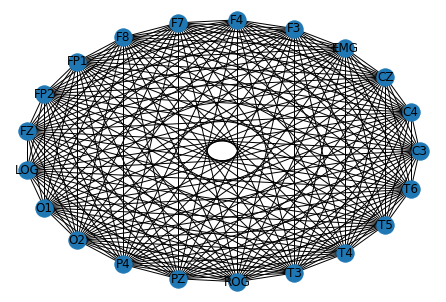

In [695]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_AEFP.csv')
quitar_uno(G)
regiones_especificas(G)

# CLMN



El valor Fiedler de toda la gráfica es 1.67138


El eigenvector Fiedler correspondiente es {'C3': 0.005, 'C4': 0.003, 'CZ': 0.006, 'EMG': -0.788, 'F3': 0.007, 'F4': 0.004, 'F7': 0.016, 'F8': 0.003, 'FP1': 0.022, 'FP2': 0.019, 'FZ': 0.006, 'LOG': 0.037, 'O1': 0.006, 'O2': 0.001, 'P3': 0.006, 'P4': 0.007, 'PZ': 0.008, 'ROG': 0.614, 'T3': 0.006, 'T5': 0.007, 'T6': 0.005}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 1.56588, 'ROG': 1.72601, 'O2': 1.55528, 'P3': 1.58731, 'F3': 1.59681, 'T5': 1.60206, 'C3': 1.58656, 'C4': 1.54145, 'T3': 1.63154, 'EMG': 1.76903, 'LOG': 1.54887, 'FZ': 1.55967, 'F8': 1.5433, 'P4': 1.59631, 'F4': 1.55826, 'CZ': 1.56187, 'T6': 1.53554, 'FP1': 1.63756, 'O1': 1.58338, 'F7': 1.61107, 'FP2': 1.61469}


EMG You are the weakest link
Quitando EMG el valor Fiedler alcanza su máximo, que es 1.76903


 Valores Fiedler por regiones

all_nodes           1.67138
izquierdo           2.23919
derecho           0.72379
central           2.0849
izquierdo+central     

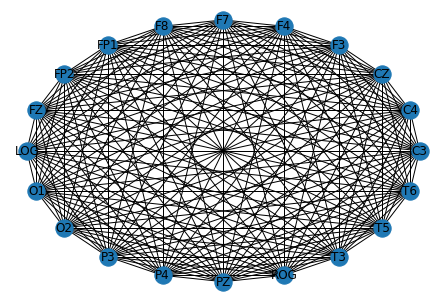

In [696]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_CLMN.csv')
quitar_uno(G)
regiones_especificas(G)

# EMNN

In [698]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_EMNN.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.79542


El eigenvector Fiedler correspondiente es {'C3': -0.045, 'C4': -0.047, 'CZ': -0.044, 'EMG': 0.977, 'F3': -0.047, 'F4': -0.042, 'F7': -0.051, 'F8': -0.05, 'FP1': -0.045, 'FP2': -0.042, 'FZ': -0.044, 'LOG': -0.039, 'O1': -0.051, 'O2': -0.053, 'P3': -0.047, 'P4': -0.046, 'PZ': -0.047, 'ROG': -0.041, 'T3': -0.05, 'T4': -0.043, 'T5': -0.052, 'T6': -0.051}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.75863, 'ROG': 0.73465, 'O2': 0.79614, 'P3': 0.76053, 'T4': 0.72952, 'F3': 0.76384, 'T5': 0.79549, 'C3': 0.74595, 'C4': 0.75763, 'T3': 0.78292, 'EMG': 5.63493, 'LOG': 0.72096, 'FZ': 0.73795, 'F8': 0.78478, 'P4': 0.75229, 'F4': 0.73548, 'CZ': 0.73766, 'T6': 0.78786, 'FP1': 0.7487, 'O1': 0.78887, 'F7': 0.78414, 'FP2': 0.73883}


EMG You are the weakest link
Quitando EMG el valor Fiedler alcanza su máximo, que es 5.63493


 Valores Fiedler por regiones

all_nodes           0.79542
izquierdo           2.39294
derecho           2.05265
c

# FGH

In [699]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_FGH.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.26219


El eigenvector Fiedler correspondiente es {'C3': -0.096, 'C4': -0.097, 'CZ': -0.096, 'EMG': -0.097, 'F3': 0.453, 'F4': -0.097, 'F7': 0.453, 'F8': -0.096, 'FP1': 0.453, 'FP2': 0.449, 'FZ': -0.096, 'LOG': -0.1, 'O1': -0.096, 'O2': -0.097, 'P3': -0.124, 'P4': -0.138, 'PZ': -0.096, 'ROG': -0.094, 'T3': -0.096, 'T4': -0.096, 'T5': -0.097, 'T6': -0.097}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.24861, 'ROG': 0.24046, 'O2': 0.25258, 'P3': 0.26046, 'T4': 0.24848, 'F3': 0.25304, 'T5': 0.2528, 'C3': 0.24369, 'C4': 0.24986, 'T3': 0.24701, 'EMG': 0.25162, 'LOG': 0.25787, 'FZ': 0.24925, 'F8': 0.24758, 'P4': 0.25583, 'F4': 0.25049, 'CZ': 0.24936, 'T6': 0.25276, 'FP1': 0.25185, 'O1': 0.24504, 'F7': 0.25329, 'FP2': 0.24359}


P3 You are the weakest link
Quitando P3 el valor Fiedler alcanza su máximo, que es 0.26046


 Valores Fiedler por regiones

all_nodes           0.26219
izquierdo           0.09894
derecho           0.12378
centra

# GH

In [700]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_GH.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.07952


El eigenvector Fiedler correspondiente es {'C3': 0.073, 'C4': 0.073, 'CZ': 0.073, 'EMG': -0.165, 'F3': 0.074, 'F4': 0.074, 'F7': 0.073, 'F8': 0.073, 'FP1': -0.358, 'FP2': 0.073, 'FZ': 0.073, 'LOG': 0.07, 'O1': 0.073, 'O2': 0.073, 'P3': 0.073, 'P4': 0.073, 'PZ': 0.073, 'ROG': 0.071, 'T3': 0.073, 'T4': -0.862, 'T5': 0.073, 'T6': 0.073}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.07658, 'ROG': 0.07131, 'O2': 0.07534, 'P3': 0.07636, 'T4': 0.0898, 'F3': 0.07807, 'T5': 0.07606, 'C3': 0.07775, 'C4': 0.07679, 'T3': 0.07732, 'EMG': 0.06678, 'LOG': 0.06816, 'FZ': 0.07748, 'F8': 0.07781, 'P4': 0.07666, 'F4': 0.07806, 'CZ': 0.07701, 'T6': 0.07683, 'FP1': 0.07234, 'O1': 0.07621, 'F7': 0.0782, 'FP2': 0.07682}


T4 You are the weakest link
Quitando T4 el valor Fiedler alcanza su máximo, que es 0.0898


 Valores Fiedler por regiones

all_nodes           0.07952
izquierdo           0.03769
derecho           0.02763
central           2.67

# GURM

In [701]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_GURM.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.3504


El eigenvector Fiedler correspondiente es {'C3': -0.042, 'C4': -0.043, 'CZ': -0.042, 'EMG': 0.974, 'F3': -0.058, 'F4': -0.055, 'F7': -0.056, 'F8': -0.055, 'FP1': -0.058, 'FP2': -0.057, 'FZ': -0.056, 'LOG': -0.011, 'O1': -0.042, 'O2': -0.044, 'P3': -0.044, 'P4': -0.08, 'PZ': -0.044, 'ROG': -0.001, 'T3': -0.052, 'T4': -0.048, 'T5': -0.043, 'T6': -0.045}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.33905, 'ROG': 0.2635, 'O2': 0.3437, 'P3': 0.34306, 'T4': 0.34098, 'F3': 0.34986, 'T5': 0.3386, 'C3': 0.3282, 'C4': 0.33266, 'T3': 0.34568, 'EMG': 0.62182, 'LOG': 0.25867, 'FZ': 0.35081, 'F8': 0.34422, 'P4': 0.34513, 'F4': 0.3433, 'CZ': 0.33065, 'T6': 0.34646, 'FP1': 0.35001, 'O1': 0.32523, 'F7': 0.34822, 'FP2': 0.34778}


EMG You are the weakest link
Quitando EMG el valor Fiedler alcanza su máximo, que es 0.62182


 Valores Fiedler por regiones

all_nodes           0.3504
izquierdo           0.67049
derecho           0.27082
centra

# JANA

In [702]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_JANA.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 6.8776


El eigenvector Fiedler correspondiente es {'C3': -0.083, 'C4': -0.128, 'CZ': -0.089, 'EMG': -0.129, 'F3': 0.003, 'F4': -0.071, 'F7': 0.041, 'F8': -0.089, 'FP1': 0.105, 'FP2': 0.098, 'FZ': 0.016, 'LOG': 0.893, 'O1': -0.101, 'O2': -0.1, 'P3': -0.089, 'P4': -0.106, 'PZ': -0.092, 'ROG': 0.218, 'T3': -0.054, 'T4': -0.061, 'T5': -0.077, 'T6': -0.104}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 6.63631, 'ROG': 6.3819, 'O2': 6.67179, 'P3': 6.62896, 'T4': 6.48208, 'F3': 6.32894, 'T5': 6.57746, 'C3': 6.60174, 'C4': 6.80514, 'T3': 6.49789, 'EMG': 6.7369, 'LOG': 7.78634, 'FZ': 6.24877, 'F8': 6.60395, 'P4': 6.70565, 'F4': 6.53809, 'CZ': 6.6223, 'T6': 6.69317, 'FP1': 6.33303, 'O1': 6.68031, 'F7': 6.43192, 'FP2': 6.36719}


LOG You are the weakest link
Quitando LOG el valor Fiedler alcanza su máximo, que es 7.78634


 Valores Fiedler por regiones

all_nodes           6.8776
izquierdo           3.07177
derecho           2.80391
central    

# JGMN

In [703]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_JGMN.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.26188


El eigenvector Fiedler correspondiente es {'C3': -0.045, 'C4': -0.045, 'CZ': -0.048, 'EMG': -0.045, 'F3': 0.977, 'F4': -0.045, 'F7': -0.045, 'F8': -0.045, 'FP1': -0.046, 'FP2': -0.046, 'FZ': -0.045, 'LOG': -0.051, 'O1': -0.048, 'O2': -0.047, 'P3': -0.048, 'P4': -0.046, 'PZ': -0.048, 'ROG': -0.048, 'T3': -0.047, 'T4': -0.047, 'T5': -0.047, 'T6': -0.046}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.25972, 'ROG': 0.26023, 'O2': 0.2513, 'P3': 0.26227, 'T4': 0.25229, 'F3': 1.77438, 'T5': 0.25593, 'C3': 0.23929, 'C4': 0.24197, 'T3': 0.25041, 'EMG': 0.24699, 'LOG': 0.2576, 'FZ': 0.24136, 'F8': 0.23946, 'P4': 0.24573, 'F4': 0.24179, 'CZ': 0.26034, 'T6': 0.2465, 'FP1': 0.252, 'O1': 0.2592, 'F7': 0.23601, 'FP2': 0.24879}


F3 You are the weakest link
Quitando F3 el valor Fiedler alcanza su máximo, que es 1.77438


 Valores Fiedler por regiones

all_nodes           0.26188
izquierdo           0.09305
derecho           1.02955
centra

# MGNA

In [704]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_MGNA.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.18789


El eigenvector Fiedler correspondiente es {'C3': 0.045, 'C4': 0.045, 'CZ': 0.045, 'EMG': 0.047, 'F3': -0.977, 'F4': 0.045, 'F7': 0.045, 'F8': 0.045, 'FP1': 0.058, 'FP2': 0.047, 'FZ': 0.045, 'LOG': 0.052, 'O1': 0.045, 'O2': 0.045, 'P3': 0.045, 'P4': 0.045, 'PZ': 0.045, 'ROG': 0.05, 'T3': 0.045, 'T4': 0.045, 'T5': 0.045, 'T6': 0.045}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.17654, 'ROG': 0.18345, 'O2': 0.17683, 'P3': 0.17514, 'T4': 0.17766, 'F3': 0.91551, 'T5': 0.17905, 'C3': 0.18156, 'C4': 0.18072, 'T3': 0.17934, 'EMG': 0.18122, 'LOG': 0.18533, 'FZ': 0.17237, 'F8': 0.17837, 'P4': 0.17768, 'F4': 0.181, 'CZ': 0.17577, 'T6': 0.17894, 'FP1': 0.18702, 'O1': 0.17922, 'F7': 0.17858, 'FP2': 0.18038}


F3 You are the weakest link
Quitando F3 el valor Fiedler alcanza su máximo, que es 0.91551


 Valores Fiedler por regiones

all_nodes           0.18789
izquierdo           0.06517
derecho           0.91923
central           2.432

# MJNN

In [705]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_MJNN.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.99859


El eigenvector Fiedler correspondiente es {'C3': 0.046, 'C4': 0.046, 'CZ': 0.047, 'EMG': 0.051, 'F3': 0.048, 'F4': 0.05, 'F7': 0.045, 'F8': 0.048, 'FP1': 0.043, 'FP2': 0.049, 'FZ': 0.047, 'LOG': 0.044, 'O1': 0.047, 'O2': 0.047, 'P3': 0.047, 'P4': 0.045, 'PZ': 0.047, 'ROG': -0.977, 'T3': 0.047, 'T4': 0.04, 'T5': 0.047, 'T6': 0.048}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.9554, 'ROG': 7.63123, 'O2': 0.95582, 'P3': 0.95793, 'T4': 0.88602, 'F3': 0.96848, 'T5': 0.95804, 'C3': 0.9538, 'C4': 0.94347, 'T3': 0.95824, 'EMG': 0.98421, 'LOG': 0.94051, 'FZ': 0.96506, 'F8': 0.96317, 'P4': 0.93389, 'F4': 0.98587, 'CZ': 0.96113, 'T6': 0.97129, 'FP1': 0.90066, 'O1': 0.96442, 'F7': 0.92925, 'FP2': 0.97948}


ROG You are the weakest link
Quitando ROG el valor Fiedler alcanza su máximo, que es 7.63123


 Valores Fiedler por regiones

all_nodes           0.99859
izquierdo           3.50755
derecho           0.41409
central           2.33

# PCM

In [706]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_PCM.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 1.74688


El eigenvector Fiedler correspondiente es {'C3': -0.043, 'C4': -0.04, 'CZ': -0.04, 'EMG': 0.975, 'F3': -0.048, 'F4': -0.043, 'F7': -0.04, 'F8': -0.042, 'FP1': -0.049, 'FP2': -0.058, 'FZ': -0.041, 'LOG': -0.097, 'O1': -0.04, 'O2': -0.04, 'P3': -0.041, 'P4': -0.042, 'PZ': -0.04, 'ROG': -0.069, 'T3': -0.041, 'T4': -0.04, 'T5': -0.04, 'T6': -0.04}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 1.64538, 'ROG': 1.72459, 'O2': 1.64845, 'P3': 1.65492, 'T4': 1.63991, 'F3': 1.708, 'T5': 1.65264, 'C3': 1.68297, 'C4': 1.63972, 'T3': 1.66692, 'EMG': 3.27271, 'LOG': 1.74423, 'FZ': 1.63466, 'F8': 1.64919, 'P4': 1.677, 'F4': 1.64795, 'CZ': 1.64694, 'T6': 1.64999, 'FP1': 1.69064, 'O1': 1.64884, 'F7': 1.64893, 'FP2': 1.70622}


EMG You are the weakest link
Quitando EMG el valor Fiedler alcanza su máximo, que es 3.27271


 Valores Fiedler por regiones

all_nodes           1.74688
izquierdo           0.85731
derecho           2.03831
central    

# RLMN

In [707]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_RLMN.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.40384


El eigenvector Fiedler correspondiente es {'C3': 0.05, 'C4': 0.05, 'EMG': 0.066, 'F3': 0.052, 'F4': 0.052, 'F7': 0.052, 'F8': 0.052, 'FP2': 0.052, 'FZ': 0.049, 'LOG': 0.057, 'O1': 0.044, 'O2': 0.049, 'P3': 0.047, 'P4': 0.048, 'PZ': 0.048, 'ROG': 0.056, 'T3': 0.052, 'T4': 0.052, 'T5': -0.974, 'T6': 0.047}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.36284, 'ROG': 0.40125, 'O2': 0.38076, 'P3': 0.35994, 'T4': 0.40005, 'F3': 0.39707, 'T5': 1.11174, 'C3': 0.38697, 'C4': 0.38215, 'T3': 0.39732, 'EMG': 0.39627, 'LOG': 0.40128, 'FZ': 0.37546, 'F8': 0.39894, 'P4': 0.36122, 'F4': 0.39404, 'T6': 0.36016, 'O1': 0.33723, 'F7': 0.40175, 'FP2': 0.39353}


T5 You are the weakest link
Quitando T5 el valor Fiedler alcanza su máximo, que es 1.11174


 Valores Fiedler por regiones

all_nodes           0.40384
izquierdo           0.1643
derecho           1.52058
central           1.71789
izquierdo+central           0.18624
derecho+central    

# RRMN

In [708]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_RRMN.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 1.1166


El eigenvector Fiedler correspondiente es {'C3': 0.074, 'C4': 0.113, 'CZ': 0.119, 'F3': -0.272, 'F4': -0.288, 'F7': -0.363, 'F8': -0.36, 'FP1': -0.225, 'FP2': -0.263, 'FZ': -0.281, 'LOG': 0.325, 'O1': 0.11, 'O2': 0.111, 'P3': 0.12, 'P4': 0.116, 'PZ': 0.112, 'ROG': 0.329, 'T3': 0.178, 'T4': 0.115, 'T5': 0.115, 'T6': 0.115}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 1.02017, 'ROG': 1.1274, 'O2': 1.02345, 'P3': 1.08535, 'T4': 1.07246, 'F3': 1.0247, 'T5': 1.07063, 'C3': 1.06171, 'C4': 1.07194, 'T3': 1.07543, 'LOG': 1.09357, 'FZ': 1.04747, 'F8': 1.17613, 'P4': 1.0297, 'F4': 1.05796, 'CZ': 1.08415, 'T6': 1.03029, 'FP1': 0.93628, 'O1': 1.02902, 'F7': 1.1539, 'FP2': 1.01208}


F8 You are the weakest link
Quitando F8 el valor Fiedler alcanza su máximo, que es 1.17613


 Valores Fiedler por regiones

all_nodes           1.1166
izquierdo           0.43701
derecho           0.46216
central           0.26541
izquierdo+central          

# VCNN

In [709]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_VCNN.csv')
quitar_uno(G)
regiones_especificas(G)

El valor Fiedler de toda la gráfica es 0.06325


El eigenvector Fiedler correspondiente es {'C3': -0.047, 'C4': -0.048, 'CZ': -0.048, 'EMG': -0.047, 'F3': -0.043, 'F4': 0.977, 'F7': -0.044, 'F8': -0.047, 'FP1': -0.044, 'FP2': -0.042, 'FZ': -0.044, 'LOG': -0.047, 'O1': -0.048, 'O2': -0.048, 'P3': -0.047, 'P4': -0.048, 'PZ': -0.048, 'ROG': -0.047, 'T3': -0.047, 'T4': -0.048, 'T5': -0.048, 'T6': -0.048}


Valores Fiedler, quitando el nodo que se indica: 
{'PZ': 0.06247, 'ROG': 0.06, 'O2': 0.06336, 'P3': 0.06179, 'T4': 0.06134, 'F3': 0.05779, 'T5': 0.06303, 'C3': 0.0615, 'C4': 0.06283, 'T3': 0.06152, 'EMG': 0.05952, 'LOG': 0.05954, 'FZ': 0.05733, 'F8': 0.05949, 'P4': 0.063, 'F4': 1.03087, 'CZ': 0.06179, 'T6': 0.06188, 'FP1': 0.05865, 'O1': 0.06117, 'F7': 0.05925, 'FP2': 0.05051}


F4 You are the weakest link
Quitando F4 el valor Fiedler alcanza su máximo, que es 1.03087


 Valores Fiedler por regiones

all_nodes           0.06325
izquierdo           0.52333
derecho           0.02633
centra

0.02162 

69
6.107793350146009
('C4', 'CZ', 'F7', 'O1', 'O2', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6')
6.10779


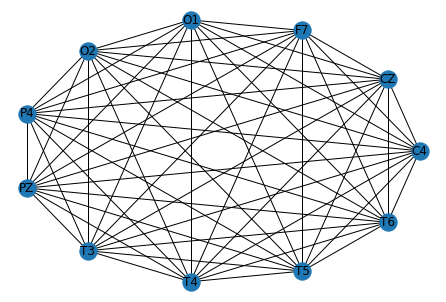

In [462]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_AEFP.csv')

print(round(nx.algebraic_connectivity(positiv(G)),5),"\n")

size = 11

maximal_ac=nx.algebraic_connectivity(positiv(G))
i=0
fv=0

for k in list(combinations(G.nodes,size)):
    if peso_grafica(positiv(G).subgraph(k))/(size-1)>max(5.5,maximal_ac):
        print(i)
        fv=nx.algebraic_connectivity(positiv(G).subgraph(k))
    else:
        fv=0
        #print(i)    
    if fv>maximal_ac:
        #print(i)
        maximal_ac=nx.algebraic_connectivity(positiv(G).subgraph(k))
        print(maximal_ac)
        nodos_selectos=k
    i = i+1                     

print(nodos_selectos)
print(round(maximal_ac,5))   

nx.draw_circular(positiv(G).subgraph(nodos_selectos),with_labels=True)            

In [583]:
G = graph_from_csv('./variaciones/CorrelacionesREM/correls_AEFP.csv')
G=positiv(G)

lap=nx.laplacian_matrix(G)

arista_selecta=choice(list(G.edges))
peso_chico=G[arista_selecta[0]][arista_selecta[1]]['weight']

for veces in range(13):
    x=choice(list(G.edges))
    if G[x[0]][x[1]]['weight']<peso_chico:
        peso_chico=G[x[0]][x[1]]['weight']
        arista_selecta=x 
    
print(arista_selecta)    
print(peso_chico)

for k in range(len(G)):
    if list(G.nodes)[k]==arista_selecta[0]:
        e0=k
    if list(G.nodes)[k]==arista_selecta[1]:
        e1=k

v=[0]*len(G.nodes)
v[e0]=-1
v[e1]=1

print(v)
print(G.nodes)

print(rayleigh(lap.A,v))

('O2', 'P3')
0.000472779516700837
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0]
['C3', 'C4', 'CZ', 'EMG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'LOG', 'O1', 'O2', 'P3', 'P4', 'PZ', 'ROG', 'T3', 'T4', 'T5', 'T6']
4.970983982075857


0.06325 



 Revisando los de tamaño  15
 Hasta ahora el máximo es  3.1024433922748713
 Revisando los de tamaño  14
 Hasta ahora el máximo es  3.112513234229519
 Revisando los de tamaño  13
 Hasta ahora el máximo es  4.959155800500306
 Revisando los de tamaño  12
 Hasta ahora el máximo es  6.0132219364194786
 Revisando los de tamaño  11
 Revisando los de tamaño  10
 Revisando los de tamaño  9
 Revisando los de tamaño  8
 Revisando los de tamaño  7
('C4', 'CZ', 'F8', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6')
6.01322


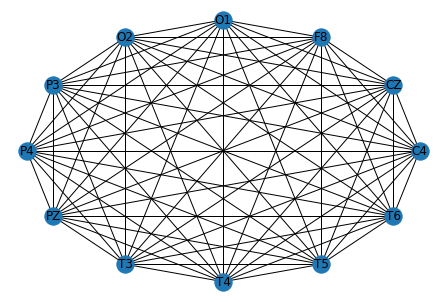

In [645]:
#Se busca la gráfica óptima para VCNN. Se hizo antes de definir la función "supgrafica_optima_ac".
#No sé si está correcto, habría que revisar. 

G = positiv(graph_from_csv('./variaciones/CorrelacionesREM/correls_VCNN.csv'))

print(round(nx.algebraic_connectivity(positiv(G)),5),"\n")
#maximal_ac=nx.algebraic_connectivity(G)

print("\n")

for i in range(7,len(G)):
    size = len(G)-i
    if size>maximal_ac:
        i=0
        fv=0

        print("\r Revisando los de tamaño ",size)
        
        for k in list(combinations(G.nodes,size)):
            lap=nx.laplacian_matrix(G.subgraph(k))
            if rayleigh(lap.A,vector_candidato(G.subgraph(k)))>maximal_ac:
                if peso_grafica(G.subgraph(k))/(size-1)>maximal_ac:   
                    fv=nx.algebraic_connectivity(G.subgraph(k))
              
                else:
                    fv=0
                if fv>maximal_ac:
                    maximal_ac=nx.algebraic_connectivity(G.subgraph(k))
                    winsound.Beep(1100, 500)
                    print("\r Hasta ahora el máximo es ", maximal_ac)
                    nodos_selectos=k
                i = i+1                     
    winsound.Beep(5700, 1100)
                   
print(nodos_selectos)
print(round(maximal_ac,5))   

nx.draw_circular(G.subgraph(nodos_selectos),with_labels=True)            

In [712]:
G = positiv(graph_from_csv('./variaciones/CorrelacionesREM/correls_EMNN.csv'))
print(round(nx.algebraic_connectivity(positiv(G)),5),"\n")
optima_EMNN=subgrafica_optima_ac(G)
nx.draw_circular(optima_RLMN,with_labels=True)            


0.79542 

Revisando los de tamaño  22


1
Revisando los de tamaño  21


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
Revisando los de tamaño  20


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
Revisando los de tamaño  

KeyboardInterrupt: 

In [717]:
G = positiv(graph_from_csv('./variaciones/CorrelacionesREM/correls_EMNN.csv'))
print(round(nx.algebraic_connectivity(positiv(G)),5),"\n")
optima_RLMN=subgrafica_optima_ac(G)
nx.draw_circular(optima_RLMN,with_labels=True)            


0.79542 

Revisando los de tamaño  22


1 0.795421613346476
Hasta ahora el máximo es  0.795421613346476


Revisando los de tamaño  21


1 0.7878628486649653
2 0.795492917832794
Hasta ahora el máximo es  0.795492917832794


3 0.7295208804958264
4 0.7829243193093707
5 0.734652679728877
6 0.7586296266019453
7 0.7522905751046647
8 0.7605316253753421
9 0.7961449457951231
Hasta ahora el máximo es  0.7961449457951231


10 0.7888682353282328
11 0.7209559593194999
12 0.73795403518578
13 0.7388256046619367
14 0.7486998195131722
15 0.7847798702483444
16 0.7841404305170241
17 0.7354810916268538
18 0.7638440647975193
19 5.634933484889577
Hasta ahora el máximo es  5.634933484889577


Revisando los de tamaño  20


Revisando los de tamaño  19


Revisando los de tamaño  18


Revisando los de tamaño  17




KeyboardInterrupt: 